In [326]:
import pandas as pd 
import numpy as np
import torch 
import copy
import matplotlib
from matplotlib import pyplot as plt

In [480]:
df = pd.read_pickle('data/in-hospital-mortality/raw_hourly_timeseries.pkl')

In [481]:
train, val, test = torch.load('data/in-hospital-mortality/tensors.pkl')
cols = torch.load('data/in-hospital-mortality/tensor_features.pkl')

In [482]:
N_DIMS = 17 

In [483]:
# INDEXES 
idx_dict = {
    'CONT': np.arange(14), 
    'CONT_MASK': np.arange(29, 43), 
    'DISC': [np.arange(14, 18), np.arange(18, 24), np.arange(24, 29)],
    'DISC_MASK': np.arange(43, 46)
}
# DISCRETE MAPPING
disc_orders = [
    ['no_response', 'to_pain', 'to_speech', 'spontaneously'], # eyes
    ['no_response', 'abnormal_extension', 'abnormal_flexion', 
              'flex-withdraws', 'localizes_pain', 'obeys_commands'], # motor 
    ['no_response', 'incomprehensible_sounds', 
               'inappropriate_words', 'confused', 'oriented']] # verbal

# SORT DISC ACCORDING TO DISC_ORDERS
import re 
cols = np.array([re.sub('^[^_]*_', '', s) for s in list(cols)] )
new_disc = []
for i,r in enumerate(idx_dict['DISC']): 
    d = dict(zip(list(cols[r]), r))
    temp = [d[j] for j in disc_orders[i]]
    new_disc.append(np.array(temp))
idx_dict['DISC'] = new_disc

In [324]:
P1 = train[0][0].detach().numpy()
P2 = train[0][1].detach().numpy()
P = np.array((P1, P2))

In [456]:
a = train[0][:2].detach().numpy()

In [461]:
a[:,:, idx_dict['CONT'][0]].shape

(2, 48)

In [474]:
cols[idx_dict['DISC_MASK'][0]]

'Glascow coma scale eye opening mask'

In [478]:
idx_dict['CONT']

range(0, 14)

In [496]:
disc_transform(a, idx_dict['DISC']).shape

(2, 48, 3)

In [463]:
disc_transform(a, idx_dict['DISC']).shape

(2, 48, 3)

In [451]:
train[0][:2].shape

torch.Size([2, 48, 46])

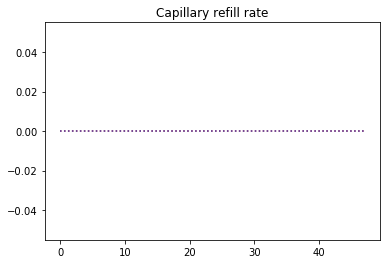

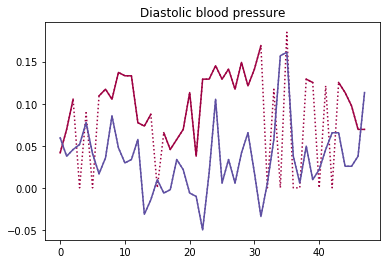

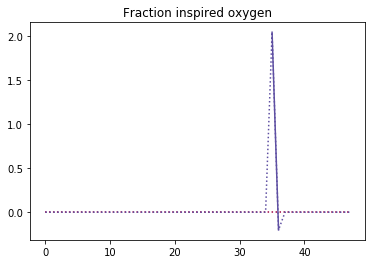

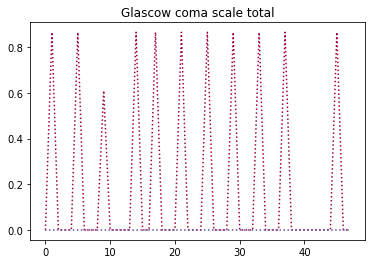

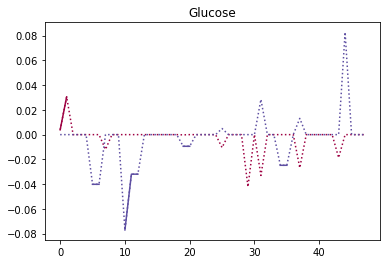

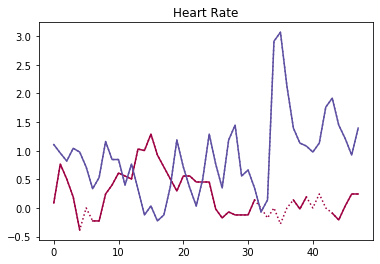

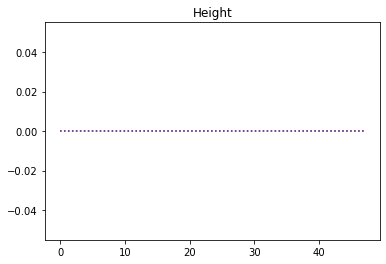

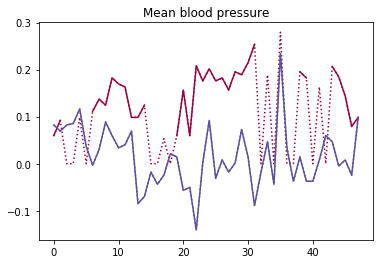

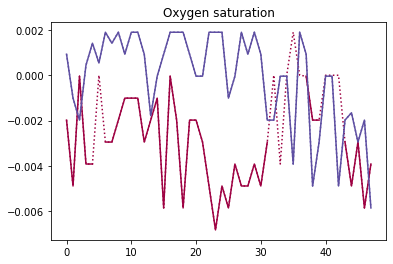

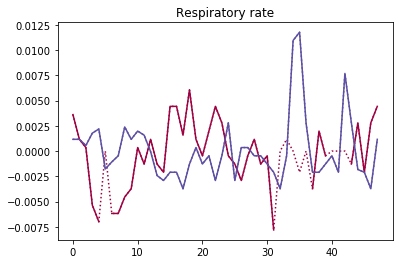

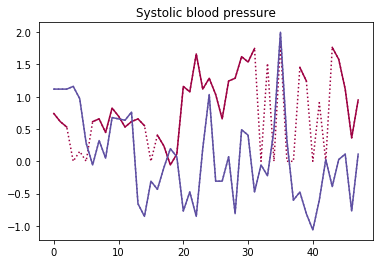

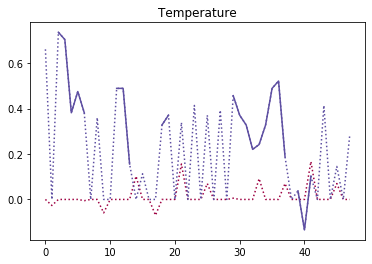

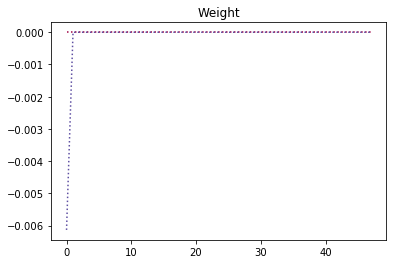

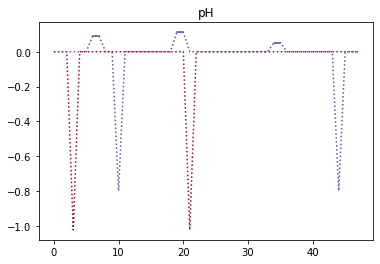

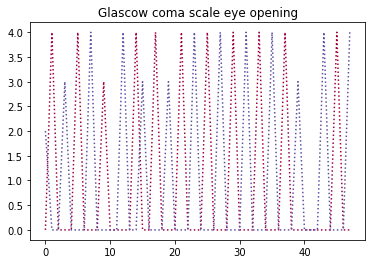

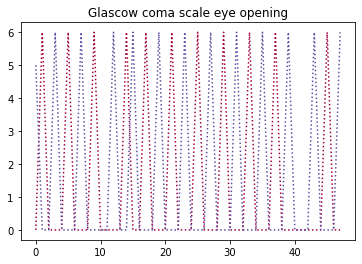

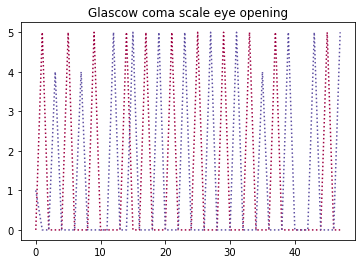

In [501]:
visualise_tensors(train[0][:2], cols, idx_dict)

In [490]:
idx_dict['CONT'].shape[0]

14

In [367]:
this.sum(axis=0)

array([1.56662837, 1.05460292, 1.77134296, 0.5979254 , 1.47996761])

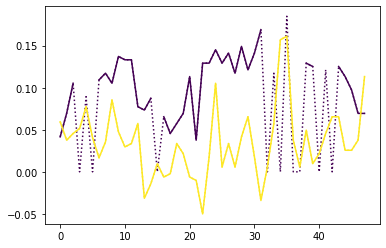

In [328]:
plot_one_fea(P[:,:,1], P[:,:,30])